Bank Marketing Data Analysis using Apache Spark

Step 1: Setup PySpark in Google Colab

In [8]:
# Step 1: Setup PySpark in Google Colab

# Install Java and Spark
!apt-get update
!apt-get install openjdk-11-jdk -y

# Remove any existing Spark installation and its archive to ensure a fresh setup
!rm -rf /opt/spark
!rm -f spark-3.5.1-bin-hadoop3.tgz

# Download Spark binaries and extract them
# Using a specific version (Spark 3.5.1 with Hadoop 3) that is known to work well in Colab environments
!wget https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!mv spark-3.5.1-bin-hadoop3 /opt/spark

# Set environment variables for JAVA_HOME and SPARK_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/opt/spark"

# Install findspark and pyspark
!pip install -q findspark pyspark

# Initialize findspark to enable PySpark to work with regular Python
import findspark
findspark.init()

# Initialize Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("BankMarketingAnalysis").getOrCreate()

print("✅ Spark Session Created Successfully")

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

Step 2: Load Data into Spark DataFrame

In [14]:
# Upload bank.csv or use existing one
file_path = "/content/bank.csv"  # Update if needed

df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)
df.printSchema()


+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

Step 3: Basic Data Inspection

In [15]:
df.describe(['age', 'balance', 'duration']).show()


+-------+------------------+------------------+------------------+
|summary|               age|           balance|          duration|
+-------+------------------+------------------+------------------+
|  count|              4521|              4521|              4521|
|   mean| 41.17009511170095|1422.6578190665782|263.96129174961294|
| stddev|10.576210958711263|3009.6381424673395|259.85663262468216|
|    min|                19|             -3313|                 4|
|    max|                87|             71188|              3025|
+-------+------------------+------------------+------------------+



Step 4: Data Filtering and Column Operations

Filter clients with balance > 1000 and create a “quarter” column based on month.

In [18]:
from pyspark.sql.functions import create_map, lit, col, quarter, to_date, concat

# Filter clients with balance > 1000
df_filtered = df.filter(df.balance > 1000)
df_filtered.select('age', 'job', 'balance').show(5)

# Add Quarter Column
month_to_num = {
    'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
    'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12
}

# Correctly flatten the dictionary items into a list of alternating keys and values
month_to_num_expr = create_map([lit(item) for sublist in month_to_num.items() for item in sublist])
df_with_month_num = df.withColumn('month_num', month_to_num_expr[col('month')])
df_with_quarter = df_with_month_num.withColumn('quarter', quarter(to_date(concat(lit('2023-'), df_with_month_num.month_num, lit('-01')))))

df_with_quarter.select('month', 'month_num', 'quarter').show(12)

+---+----------+-------+
|age|       job|balance|
+---+----------+-------+
| 30|unemployed|   1787|
| 33|  services|   4789|
| 35|management|   1350|
| 30|management|   1476|
| 39|  services|   9374|
+---+----------+-------+
only showing top 5 rows

+-----+---------+-------+
|month|month_num|quarter|
+-----+---------+-------+
|  oct|       10|      4|
|  may|        5|      2|
|  apr|        4|      2|
|  jun|        6|      2|
|  may|        5|      2|
|  feb|        2|      1|
|  may|        5|      2|
|  may|        5|      2|
|  may|        5|      2|
|  apr|        4|      2|
|  may|        5|      2|
|  apr|        4|      2|
+-----+---------+-------+
only showing top 12 rows



Step 5: GroupBy and Aggregation
Average balance & median age by job type

In [19]:
from pyspark.sql import Window

# Average balance per job
avg_balance = df.groupBy("job").agg(avg("balance").alias("avg_balance"))
avg_balance.show()

# Median age using window function
windowSpec = Window.partitionBy("job").orderBy("age")
median_age = df.withColumn("row_num", row_number().over(windowSpec))
median_age.groupBy("job").agg(expr('percentile_approx(age, 0.5)').alias('median_age')).show()


+-------------+------------------+
|          job|       avg_balance|
+-------------+------------------+
|   management|1766.9287925696594|
|      retired| 2319.191304347826|
|      unknown|1501.7105263157894|
|self-employed|1392.4098360655737|
|      student|1543.8214285714287|
|  blue-collar| 1085.161733615222|
| entrepreneur|          1645.125|
|       admin.|  1226.73640167364|
|   technician|     1330.99609375|
|     services|1103.9568345323742|
|    housemaid|2083.8035714285716|
|   unemployed|       1089.421875|
+-------------+------------------+

+-------------+----------+
|          job|median_age|
+-------------+----------+
|   management|        38|
|      retired|        59|
|      unknown|        49|
|self-employed|        40|
|      student|        26|
|  blue-collar|        39|
| entrepreneur|        41|
|       admin.|        38|
|   technician|        38|
|     services|        37|
|    housemaid|        49|
|   unemployed|        41|
+-------------+----------+



Total clients for each marital status who subscribed

In [20]:
df.groupBy("marital").agg(sum(when(col("y")=="yes",1).otherwise(0)).alias("subscribed_clients")).show()


+--------+------------------+
| marital|subscribed_clients|
+--------+------------------+
|divorced|                77|
| married|               277|
|  single|               167|
+--------+------------------+



Step 6: UDF for Age Grouping

In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def age_group(age):
    if age < 30:
        return '<30'
    elif age <= 60:
        return '30-60'
    else:
        return '>60'

age_udf = udf(age_group, StringType())

df = df.withColumn("age_group", age_udf(col("age")))
df.select("age", "age_group").show(10)


+---+---------+
|age|age_group|
+---+---------+
| 30|    30-60|
| 33|    30-60|
| 35|    30-60|
| 30|    30-60|
| 59|    30-60|
| 35|    30-60|
| 36|    30-60|
| 39|    30-60|
| 41|    30-60|
| 43|    30-60|
+---+---------+
only showing top 10 rows



Step 7: Advanced Data Transformations
Subscription rate by education leve

In [22]:
df.groupBy("education").agg(
    (sum(when(col("y")=="yes",1).otherwise(0)) / count("*") * 100).alias("subscription_rate_%")
).orderBy(col("subscription_rate_%").desc()).show()


+---------+-------------------+
|education|subscription_rate_%|
+---------+-------------------+
| tertiary| 14.296296296296296|
|secondary| 10.624457935819601|
|  unknown|  10.16042780748663|
|  primary|   9.43952802359882|
+---------+-------------------+



Top 3 professions with highest loan default rate

In [23]:
df.groupBy("job").agg(
    (sum(when(col("default")=="yes",1).otherwise(0)) / count("*") * 100).alias("default_rate_%")
).orderBy(col("default_rate_%").desc()).show(3)


+-------------+-----------------+
|          job|   default_rate_%|
+-------------+-----------------+
| entrepreneur|4.166666666666666|
|   unemployed|          2.34375|
|self-employed|2.185792349726776|
+-------------+-----------------+
only showing top 3 rows



Step 8: String Manipulation and Date Functions

In [24]:
# Concatenate job and marital
df = df.withColumn("job_marital", concat_ws("_", col("job"), col("marital")))

# Convert 'contact' to uppercase
df = df.withColumn("contact_upper", upper(col("contact")))

df.select("job_marital", "contact_upper").show(5)


+-------------------+-------------+
|        job_marital|contact_upper|
+-------------------+-------------+
| unemployed_married|     CELLULAR|
|   services_married|     CELLULAR|
|  management_single|     CELLULAR|
| management_married|      UNKNOWN|
|blue-collar_married|      UNKNOWN|
+-------------------+-------------+
only showing top 5 rows



Step 9: Visualization (Convert to Pandas)

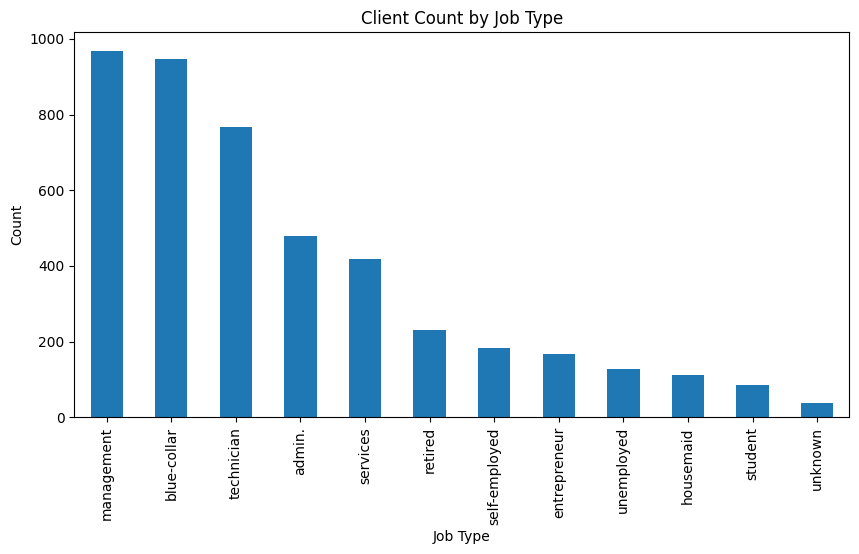

In [25]:
import matplotlib.pyplot as plt

pandas_df = df.toPandas()

# Bar plot: count of clients by job
plt.figure(figsize=(10,5))
pandas_df['job'].value_counts().plot(kind='bar')
plt.title("Client Count by Job Type")
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.show()


Step 10: Complex Insights Queries
Month with highest contacts and success rate

In [26]:
df.groupBy("month").agg(
    count("*").alias("total_contacts"),
    (sum(when(col("y")=="yes",1).otherwise(0))/count("*")*100).alias("success_rate_%")
).orderBy(col("total_contacts").desc()).show(1)


+-----+--------------+-----------------+
|month|total_contacts|   success_rate_%|
+-----+--------------+-----------------+
|  may|          1398|6.652360515021459|
+-----+--------------+-----------------+
only showing top 1 row



Average duration of contact (subscribed vs not)

In [27]:
df.groupBy("y").agg(avg("duration").alias("avg_duration")).show()


+---+-----------------+
|  y|     avg_duration|
+---+-----------------+
| no|         226.3475|
|yes|552.7428023032629|
+---+-----------------+



Step 11: Correlation Between Age and Balance

In [28]:
corr_val = df.stat.corr("age", "balance")
print(f"Correlation between Age and Balance: {corr_val:.3f}")


Correlation between Age and Balance: 0.084


Step 12: Exploring Loan Defaults

+-------+-----+
|default|count|
+-------+-----+
|     no| 4445|
|    yes|   76|
+-------+-----+



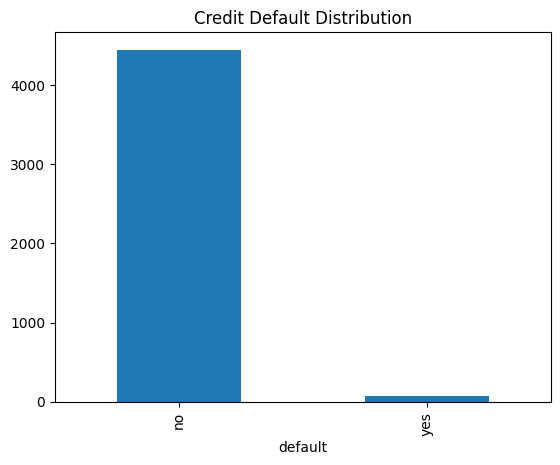

In [29]:
default_stats = df.groupBy("default").count()
default_stats.show()

pandas_df['default'].value_counts().plot(kind='bar', title="Credit Default Distribution")
plt.show()


Step 13: Contact Method Analysis

In [30]:
df.groupBy("contact").agg(
    (sum(when(col("y")=="yes",1).otherwise(0))/count("*")*100).alias("success_rate_%")
).orderBy(col("success_rate_%").desc()).show()


+---------+-----------------+
|  contact|   success_rate_%|
+---------+-----------------+
|telephone|14.61794019933555|
| cellular| 14.3646408839779|
|  unknown|4.607250755287009|
+---------+-----------------+



Step 14: Spark SQL Queries

In [31]:
# Register a Temp View
df.createOrReplaceTempView("bank_data")

# SQL Query: Average balance per age group
spark.sql("""
SELECT age_group, AVG(balance) AS avg_balance, COUNT(*) AS clients
FROM bank_data
GROUP BY age_group
ORDER BY avg_balance DESC
""").show()

# SQL Query: Most common job types
spark.sql("""
SELECT job, COUNT(*) AS job_count
FROM bank_data
GROUP BY job
ORDER BY job_count DESC
LIMIT 5
""").show()


+---------+------------------+-------+
|age_group|       avg_balance|clients|
+---------+------------------+-------+
|      >60|2676.3543307086616|    127|
|    30-60|1426.8755112474437|   3912|
|      <30|1058.0954356846473|    482|
+---------+------------------+-------+

+-----------+---------+
|        job|job_count|
+-----------+---------+
| management|      969|
|blue-collar|      946|
| technician|      768|
|     admin.|      478|
|   services|      417|
+-----------+---------+

